# Healthy vs Unhealthy prediction system

#### Aim:

Finding the best machine learning algortithm to asses whether patients are at risk of having being unhealthy or not.

Notes:
    
Unique ID - Refers to each individual patient that has been assessed  
Outcome - This is the target. The number 0 represents the healthy patients and 1 represents the unhealthy patients.

## Load our modules and load data into a dataframe:

In [1]:
# Importing necessary modules:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn import model_selection
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.metrics         import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model    import LogisticRegression
from sklearn.tree            import DecisionTreeClassifier
from sklearn.ensemble        import RandomForestClassifier
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes     import GaussianNB
from sklearn.svm             import SVC

import warnings
warnings.filterwarnings('ignore')


In [2]:
data = pd.read_csv('patients_dataset.csv')
data.head()

,Unique_ID,# Pregnancies,Blood Chemestry~I,Blood Chemisty~II,Blood Chemisty~III,Blood Pressure,Skin Thickness,BMI,Genetic Predisposition Factor,Age,Air Qual'ty Index,$tate,Outcome
0,5642197,1,87.0,77.0,0,68,34.0,37.6,0.401,24,1.0,GA,0
1,5642863,3,187.0,200.0,0,70,22.0,36.4,0.408,36,6.0,CT,1
2,5642175,7,83.0,71.0,0,78,26.0,29.3,0.767,36,9.0,OR,0
3,5642237,4,92.0,0.0,0,80,0.0,42.2,0.237,29,11.0,NY,0
4,5642209,1,89.0,25.0,0,24,19.0,27.8,0.559,21,33.0,CA,0


### Taking a look at the data - data types

Our dataset is mostly made up of numerical data variables and one categorical variable. We do not need to make any changes to the types, as they are already correctly inferred, as shown below.

From the graph below, we can see that half as many people are unhealthy than those who are healthy. Therefore our dataset is skewed. A machine learning model will not be able to work to its best ability if the data is skewed.

In [3]:
print("Column datatypes: ")
print(data.dtypes)

Column datatypes: 
Unique_ID                          int64
# Pregnancies                      int64
Blood Chemestry~I                float64
Blood Chemisty~II                float64
Blood Chemisty~III                 int64
Blood Pressure                     int64
Skin Thickness                   float64
BMI                              float64
Genetic Predisposition Factor    float64
Age                                int64
Air Qual'ty Index                float64
$tate                             object
Outcome                            int64
dtype: object


#### Target Data

Percentage of healthy patients: 34.9 % (1340 patients)
Percentage of unhealthy patients:  65.1 % (2500 patients)


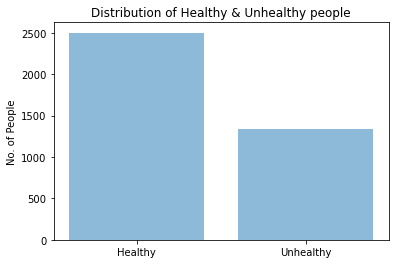

In [4]:
x = pd.DataFrame(data.groupby(['Outcome'])['Outcome'].count())

y = data['Outcome']
print(f'Percentage of healthy patients: {round(y.value_counts(normalize=True)[1]*100,2)} % ({y.value_counts()[1]} patients)\nPercentage of unhealthy patients:  {round(y.value_counts(normalize=True)[0]*100,2)} % ({y.value_counts()[0]} patients)' )

objects = ('Healthy', 'Unhealthy')
y_pos = np.arange(len(objects))
performance = [x.Outcome[0], x.Outcome[1]]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('No. of People')
plt.title('Distribution of Healthy & Unhealthy people')

plt.show()

## Data Cleaning

Steps taken during data cleaning:

1. The names of the columns of the dataset are not neat. We begin by dealing with any grammatical errors, spelling mistakes etc.
2. The Unique_ID column refers to each patient that was tested, however there are duplicated values which must be removed.
    Method:  
    a. Find out how many unique values there are in the column. This is how many entries there should be in our dataframe.  
    b. Drop any rows which are exact duplicates.  
    c. For rows that are not exact duplicates, we find the column where there is a discrepency and check if there are any differences in the outcome value. If not, we can remove the column and hence the duplicated rows. 
3. Dealing with missing values.

#### Step 1. Column names

In [5]:
# Tidy up the names of the dataframe

new_names =  {'# Pregnancies': 'Pregnancies',
              'Blood Chemestry~I': 'BloodChemistryI',
              'Blood Chemisty~II': 'BloodChemistryII',
              'Blood Chemisty~III': 'BloodChemistryIII',
              'Blood Pressure': 'BloodPressure',
              'Skin Thickness': 'SkinThickness',
              'Genetic Predisposition Factor': 'GeneticPredispositionFactor',
              "Air Qual'ty Index": 'AirQualityIndex',
              '$tate': 'State'}

data.rename(columns = new_names, inplace = True)

#### Step 2. Duplicated values
##### 2a.

In [6]:
Unique_ID_list = data.Unique_ID.values.tolist()
print(f"Our initial dataset has {len(Unique_ID_list)} entries")
print("Find out how many Unique_ID values exist:", len(list(set(Unique_ID_list))))
print("Is each entry in the dataframe, related to a unique ID?", data['Unique_ID'].is_unique)

Our initial dataset has 3840 entries
Find out how many Unique_ID values exist: 768
Is each entry in the dataframe, related to a unique ID? False


##### 2b.

In [7]:
df = data.drop_duplicates()
print("Is each entry in the dataframe, related to a unique ID?", df['Unique_ID'].is_unique)

Is each entry in the dataframe, related to a unique ID? False


##### 2c.
After looking at the dataset, we can notice that duplicates are mostly different on the 'Blood Chemisty~III' column. Therefore we can check to see if this is the only column with differences. This can be done by dropping the column and seeing if there are any duplicates. If we have 768 entries after dropping the column, it means there are no longer any duplicates. 

Note: This was tested and it was confirmed that the bloodchemistry3 column is the only column with differences. Therefore i have commented out the check, to be able to drop bloodchemistry3 in the next box of code.


In [8]:
# df.drop("BloodChemistryIII", inplace = True, axis = 1)
# blood_chem_3_check = df.drop_duplicates()
# len(blood_chem_3_check)

This confirms the blood chemisty III column is the only column with differences. Therefore we can spread these out into multiple columns.

In [9]:
grouped = df.groupby('Unique_ID').agg({'BloodChemistryIII': list})
grouped = pd.DataFrame(grouped["BloodChemistryIII"].to_list(), columns=['BloodChemistryIII_1', 'BloodChemistryIII_2', 'BloodChemistryIII_3', 'BloodChemistryIII_4', 'BloodChemistryIII_5'])

extracted_columns = grouped[['BloodChemistryIII_1', 'BloodChemistryIII_2', 'BloodChemistryIII_3', 'BloodChemistryIII_4', 'BloodChemistryIII_5']]

print("Number of rows for the blood chem 3 dataframe:", len(grouped))

df.drop("BloodChemistryIII", inplace = True, axis = 1)
df = df.drop_duplicates()

print("length of dataframe after blood chem 3 column is dropped and duplicated rows are removed:", len(df))

df = df.join(extracted_columns)
print("length of final dataframe:", len(df))

Number of rows for the blood chem 3 dataframe: 768
length of dataframe after blood chem 3 column is dropped and duplicated rows are removed: 768
length of final dataframe: 768


#### Step 3. Missing values

From below, we can see that only a few columns have any null/missing values.  These are: 
1. BloodChemistryI, 
2. BloodChemistryII, 
3. SkinThickness,
4. AirQualityIndex.
5. BloodChemistryIII (1-5)

In [10]:
def missing (df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values

missing(df)

,Missing_Number,Missing_Percent
BloodChemistryIII_5,268,0.348958
BloodChemistryIII_4,255,0.332031
BloodChemistryIII_3,254,0.330729
BloodChemistryIII_2,254,0.330729
BloodChemistryIII_1,254,0.330729
AirQualityIndex,6,0.007812
BloodChemistryI,5,0.006510
BloodChemistryII,2,0.002604
SkinThickness,1,0.001302
Outcome,0,0.000000


##### We use boxplots to understand the distribution of missing values. 

From the below box plots, we can see that BloodChemistryII has many outliers, so we do NOT use the mean as it will skew the data. Therefore we can use the modal value or median value. In this problem we have gone with the modal value for BloodChemistyII and mean values for BloodChemI, SkinThickness adn AirQualityIndex.

For the BloodChemistryIII columns we have left the empty boxes as NaN/0

As the other box plots do not have many outliers, we use their mean value.

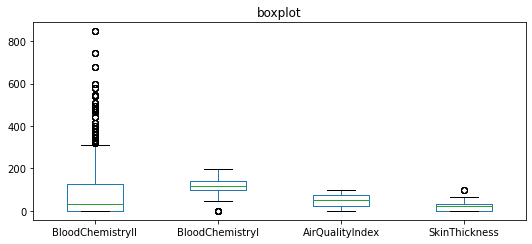

In [11]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Set the figure size
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

# Pandas dataframe
# data = pd.DataFrame({"Box1": np.random.rand(10), "Box2": np.random.rand(10)})

# Plot the dataframe
ax = data[['BloodChemistryII', 'BloodChemistryI',
          'AirQualityIndex','SkinThickness']].plot(kind='box', title='boxplot')

# Display the plot
plt.show()

In [12]:
df['BloodChemistryII'] = df['BloodChemistryII'].fillna(df['BloodChemistryII'].mode()[0])


In [13]:
mean_value_BloodChemistryI = df['BloodChemistryI'].mean()
mean_value_SkinThickness = df['SkinThickness'].mean()
mean_value_AirQualityIndex = df['AirQualityIndex'].mean()

df['BloodChemistryI'].fillna(value=mean_value_BloodChemistryI, inplace=True)
df['SkinThickness'].fillna(value=mean_value_SkinThickness, inplace=True)
df['AirQualityIndex'].fillna(value=mean_value_AirQualityIndex, inplace=True)



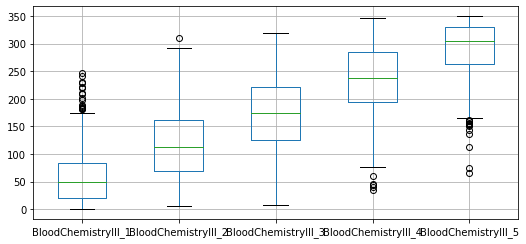

In [14]:
np.random.seed(1234)

boxplot = df.boxplot(column=['BloodChemistryIII_1', 'BloodChemistryIII_2', 'BloodChemistryIII_3', 
                             'BloodChemistryIII_4','BloodChemistryIII_5'])  

In [15]:
df = df.fillna(0)

In [16]:
#Can check the remaining missing values:
# missing(df)

# Categorical Data

##### We only have one categorical data column, which is the State. We use the mutual information score to assess how useful it is in our dataframe. The closer to zero, the less useful the score. If this is the case (SPOILER! it is), we drop this column from our dataset.

The updated dataframe is shown below. 

In [17]:
from sklearn.metrics import mutual_info_score
mis = mutual_info_score(df['State'], df['Outcome']) 
print("The Mutual Information Score is: ", mis)
df.drop("State", inplace = True, axis = 1)
df

The Mutual Information Score is:  0.04856527735963032


,Unique_ID,Pregnancies,BloodChemistryI,BloodChemistryII,BloodPressure,SkinThickness,BMI,GeneticPredispositionFactor,Age,AirQualityIndex,Outcome,BloodChemistryIII_1,BloodChemistryIII_2,BloodChemistryIII_3,BloodChemistryIII_4,BloodChemistryIII_5
0,5642197,1,87.0,77.0,68,34.0,37.6,0.401,24,1.0,0,10.0,22.0,45.0,228.0,333.0
1,5642863,3,187.0,200.0,70,22.0,36.4,0.408,36,6.0,1,61.0,146.0,193.0,338.0,342.0
2,5642175,7,83.0,71.0,78,26.0,29.3,0.767,36,9.0,0,56.0,96.0,115.0,172.0,229.0
3,5642237,4,92.0,0.0,80,0.0,42.2,0.237,29,11.0,0,64.0,66.0,86.0,207.0,245.0
4,5642209,1,89.0,25.0,24,19.0,27.8,0.559,21,33.0,0,33.0,114.0,150.0,286.0,313.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2533,5642475,2,123.0,165.0,48,32.0,42.1,0.520,26,89.0,0,0.0,0.0,0.0,0.0,0.0
2559,5642685,1,119.0,220.0,86,39.0,45.6,0.808,29,63.0,1,0.0,0.0,0.0,0.0,0.0
2685,5642210,1,89.0,94.0,66,23.0,28.1,0.167,21,84.0,0,0.0,0.0,0.0,0.0,0.0
2733,5642438,1,117.0,106.0,60,23.0,33.8,0.466,27,50.0,0,0.0,0.0,0.0,0.0,0.0


# Visual Analysis of Numerical Data

##### We now look at the numerical data columns. 

Steps:

1. Summarise the statistical measures for each column. 
2. Understand how the data is skewed and the effects on the result of our prediction model.

##### Step 1. Statistical summary

In [18]:
numerical = ['Pregnancies', 'BloodChemistryI', 'BloodChemistryII','BloodPressure','SkinThickness',
               'BMI','GeneticPredispositionFactor','Age','AirQualityIndex']

df[numerical].describe()

,Pregnancies,BloodChemistryI,BloodChemistryII,BloodPressure,SkinThickness,BMI,GeneticPredispositionFactor,Age,AirQualityIndex
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.917431,79.611979,69.105469,20.542373,31.992578,0.471876,33.513021,49.107612
std,3.369578,31.933311,115.256555,19.355807,15.951375,7.884160,0.331329,13.729833,29.065882
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,0.000000,62.000000,0.000000,27.300000,0.243750,24.000000,24.000000
50%,3.000000,117.000000,27.000000,72.000000,23.000000,32.000000,0.372500,29.000000,49.107612
75%,6.000000,140.250000,126.250000,80.000000,32.000000,36.600000,0.626250,41.000000,72.000000
max,17.000000,199.000000,846.000000,122.000000,99.000000,67.100000,2.420000,230.000000,100.000000


##### Step 2. Skewness

Based on the skewness values below, we can see that air quality is the least skewed set of data. Age should also be more flatlined, but instead has a strong positive skew shape. This is likely to negatively affect our results and lead to overfitting. The positive skew for pregnancies is expected, especially considering the age of the people being questioned.

Data such as gender, glucose levels, income etc is likely to tell us more information when paired with the existing dataset. If we were to collect more data, these are factors i think would be worth considering.

In [19]:
df[numerical].skew()

Pregnancies                    0.901674
BloodChemistryI                0.173364
BloodChemistryII               2.275742
BloodPressure                 -1.843608
SkinThickness                  0.108305
BMI                           -0.428982
GeneticPredispositionFactor    1.919911
Age                            4.498376
AirQualityIndex               -0.008394
dtype: float64

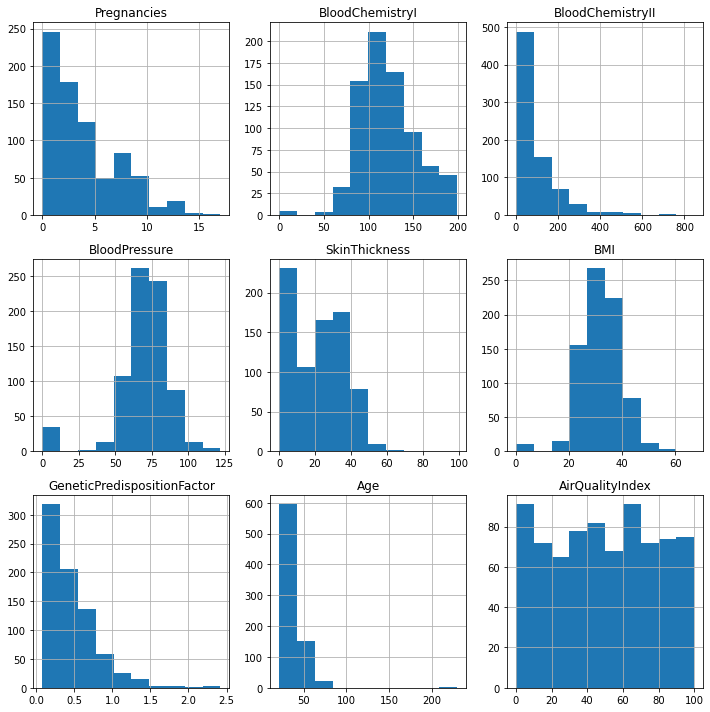

In [20]:
df[numerical].hist(figsize=(10,10));

### Correlation between all columns:

We use a correlation heatmap to see how well each column correlates with one another, as well as with the outcome of the dataset. The further away the correlation coefficient is from zero, the stronger the relationship between the two variables.

Correlation of columns with Output Variable:
BloodChemistryIII_3            0.007992
BloodChemistryIII_5            0.008073
BloodChemistryIII_1            0.009007
BloodChemistryIII_4            0.012458
BloodChemistryIII_2            0.020471
AirQualityIndex                0.052044
BloodPressure                  0.065068
SkinThickness                  0.074485
BloodChemistryII               0.128310
GeneticPredispositionFactor    0.173844
Age                            0.189642
Pregnancies                    0.221898
BMI                            0.292695
BloodChemistryI                0.465168
Unique_ID                      0.825567
Outcome                        1.000000
Name: Outcome, dtype: float64


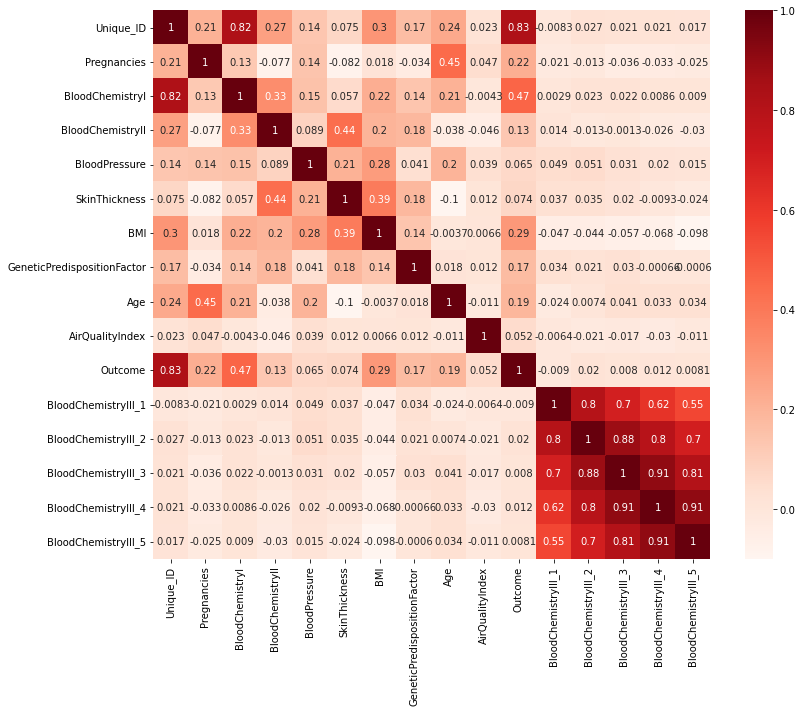

In [21]:
#Correlation with output variable
cor = df.corr()
cor_target = abs(cor["Outcome"])
print("Correlation of columns with Output Variable:")
print(cor_target.sort_values())
# df.sort_values(by=['col1', 'col2'])

#Using Pearson Correlation
plt.figure(figsize=(12,10))
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

# Compare methods to find the best model for prediction of a disease.
### We are going to be using supervised models, since we already know the outcome.

#### Steps:

1. Load and split the data into a train and test set.
2. Train our models using the training data. The models we are testing include:
    a. Logistic Regression  
    b. Linear Discriminant Analysis  
    c. K-Neighbours Classifier  
    d. Decision Trees  
    e. Random Forest  
    f. Gaussian Naive Bayes  
    g. Support Vector Machine  
3. Plot a boxplot to compare results of training
4. Find the accuracy score using the test dataset

In [22]:
df.columns

Index(['Unique_ID', 'Pregnancies', 'BloodChemistryI', 'BloodChemistryII',
       'BloodPressure', 'SkinThickness', 'BMI', 'GeneticPredispositionFactor',
       'Age', 'AirQualityIndex', 'Outcome', 'BloodChemistryIII_1',
       'BloodChemistryIII_2', 'BloodChemistryIII_3', 'BloodChemistryIII_4',
       'BloodChemistryIII_5'],
      dtype='object')

##### Step 1.

In [23]:
Columns = ['Pregnancies', 'BloodChemistryI','BMI','Age', 'BloodChemistryIII_1', 'BloodChemistryIII_2', 'BloodChemistryIII_3',
           'BloodChemistryIII_4', 'BloodChemistryIII_5']

X = df[Columns] 
Y = df[['Outcome']]  #the target output

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.4,random_state=100)

##### Step 2 & 3.

In [65]:
# create all the machine learning models
models = []
models.append(('LR',  LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART',DecisionTreeClassifier()))
models.append(('RF',  RandomForestClassifier(n_estimators=10)))
models.append(('NB',  GaussianNB()))
models.append(('SVM', SVC(probability=True)))

The mean training accuracy of the results are:
LR: 0.747826 (0.080874)
LDA: 0.758696 (0.074327)
KNN: 0.691304 (0.085200)
CART: 0.700000 (0.056522)
RF: 0.743478 (0.071310)
NB: 0.763043 (0.042876)
SVM: 0.734783 (0.082951)


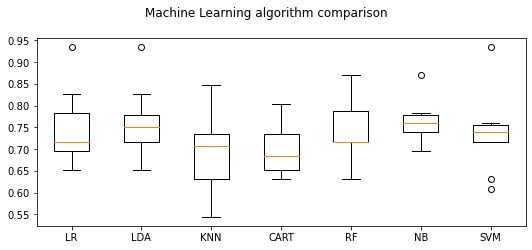

In [66]:
# 10-fold cross validation
print("The mean training accuracy of the results are:")
results = []
names = []
for name, model in models:
#     kfold = KFold(n_splits=10, random_state=seed)
    kfold = KFold(n_splits=10, random_state=None)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring="accuracy")
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Machine Learning algorithm comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [68]:
clf_RF  = RandomForestClassifier(n_estimators=10, random_state=None)
clf_RF.fit(X_train, y_train)
y_pred_proba_RF = clf_RF.predict_proba(X_test)[::,1]
fpr_RF, tpr_RF, _ = metrics.roc_curve(y_test,  y_pred_proba_RF) 


clf_LR  = LogisticRegression()
clf_LR.fit(X_train, y_train)
y_pred_proba_LR = clf_LR.predict_proba(X_test)[::,1]
fpr_LR, tpr_LR, _ = metrics.roc_curve(y_test,  y_pred_proba_LR)


clf_LDA  = LinearDiscriminantAnalysis()
clf_LDA.fit(X_train, y_train)
y_pred_proba_LDA = clf_LDA.predict_proba(X_test)[::,1]
fpr_LDA, tpr_LDA, _ = metrics.roc_curve(y_test,  y_pred_proba_LDA)

clf_KNN  = KNeighborsClassifier()
clf_KNN.fit(X_train, y_train)
y_pred_proba_KNN = clf_KNN.predict_proba(X_test)[::,1]
fpr_KNN, tpr_KNN, _ = metrics.roc_curve(y_test,  y_pred_proba_KNN)


clf_DT  = DecisionTreeClassifier(random_state=None)
clf_DT.fit(X_train, y_train)
y_pred_proba_DT = clf_DT.predict_proba(X_test)[::,1]
fpr_DT, tpr_DT, _ = metrics.roc_curve(y_test,  y_pred_proba_DT)


clf_NB  = GaussianNB()
clf_NB.fit(X_train, y_train)
y_pred_proba_NB= clf_NB.predict_proba(X_test)[::,1]
fpr_NB, tpr_NB, _ = metrics.roc_curve(y_test,  y_pred_proba_NB)


##### Step 4. Evaluation

For classification models there are the following evaluation metrics we can use:

1. Accuracy.

Accuracy is used when there are equal or almost equal number of samples belonging to each class. Therefore since there are roughly 1300 unhealthy people sampled in comparison to the 2500 healthy people, we do not use the accuracy metric. Accuracy is used when there are equal or almost equal number of samples belonging to each class. Therefore since there are roughly 1300 unhealthy people sampled in comparison to the 2500 healthy people, we do not use the accuracy metric.
     
2. Logarithmic Loss.

Log loss measures the UNCERTAINTY of the probabilities of the model by comparing them to the true labels and penalising the false classifications. Smaller the value, better is the model i.e. smaller the logloss, better is the model i.e. smaller the UNCERTAINTY, better is the model.Smaller the value, better is the model i.e. smaller the logloss, better is the model i.e. smaller the UNCERTAINTY, better is the model.Log loss measures the UNCERTAINTY of the probabilities of the model by comparing them to the true labels and penalising the false classifications. Smaller the value, better is the model i.e. smaller the logloss, better is the model i.e. smaller the UNCERTAINTY, better is the model.Smaller the value, better is the model i.e. smaller the logloss, better is the model i.e. smaller the UNCERTAINTY, better is the model.


In [43]:
# calculate logloss

logloss_LR = cross_val_score(LogisticRegression(), X_train, y_train, cv = kfold, scoring = 'neg_log_loss').mean()
logloss_RF = cross_val_score(RandomForestClassifier(n_estimators=10), X_train, y_train, cv = kfold, scoring = 'neg_log_loss').mean()
logloss_LDA = cross_val_score(LinearDiscriminantAnalysis(), X_train, y_train, cv = kfold, scoring = 'neg_log_loss').mean()
logloss_KNN = cross_val_score(KNeighborsClassifier(), X_train, y_train, cv = kfold, scoring = 'neg_log_loss').mean()
logloss_CART = cross_val_score(DecisionTreeClassifier(), X_train, y_train, cv = kfold, scoring = 'neg_log_loss').mean()
logloss_NB = cross_val_score(GaussianNB(), X_train, y_train, cv = kfold, scoring = 'neg_log_loss').mean()
logloss_SVM = cross_val_score(SVC(), X_train, y_train, cv = kfold, scoring = 'neg_log_loss').mean()

Logloss_results = {'logloss_LR': logloss_LR,
        'logloss_RF':logloss_RF, 
        'logloss_LDA':logloss_LDA, 
        'logloss_KNN':logloss_KNN, 
        'logloss_CART':logloss_CART, 
        'logloss_NB':logloss_NB, 
        'logloss_SVM':logloss_SVM }

Logloss_results

{'logloss_LR': -0.5319842397494371,
 'logloss_RF': -1.3822758685031704,
 'logloss_LDA': -0.511686217326333,
 'logloss_KNN': -2.35890035156057,
 'logloss_CART': -10.587012700640894,
 'logloss_NB': -0.5081153826234455,
 'logloss_SVM': nan}

From the above results of Logloss we see that the smallest value is Decision Trees. Therefore suggesting it has the least amount of uncertainty.

3. ROC

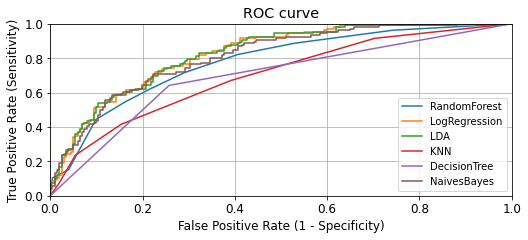

In [71]:
plt.plot(fpr_RF, tpr_RF, label="RandomForest")
plt.plot(fpr_LR, tpr_LR, label="LogRegression")
plt.plot(fpr_LDA, tpr_LDA, label="LDA")
plt.plot(fpr_KNN, tpr_KNN, label="KNN")
plt.plot(fpr_DT, tpr_DT, label="DecisionTree")
plt.plot(fpr_NB, tpr_NB, label="NaivesBayes")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right", fontsize=10)
plt.grid(True)

If we have a perfect model, all the events will have a probability score of 1 and all non-events will have a score of 0. For such a model, the area under the ROC will be a perfect 1.

So, if we trace the curve from bottom left, the value of probability cutoff decreases from 1 towards 0. If we have a good model, more of the real events should be predicted as events, resulting in high sensitivity and low FPR. In that case, the curve will rise steeply covering a large area before reaching the top-right.

Therefore, the larger the area under the ROC curve, the better is the model.

From the curves above we can concude that LDA and Logistic Regression are the top performers.

Other metrics include:

3.5. AUC
4. Confusion Matrix.
5. Classification Report.